# Plot latent space of scDeepCluster

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import umap
import scanpy as sc
from collections import OrderedDict
from sklearn.cluster import KMeans

sc.logging.print_version_and_date()
sns.set(style='white', context='notebook', rc={'figure.figsize': (9, 5)})
np.random.seed(42)

Running Scanpy 1.5.1, on 2020-07-22 03:31.


Load the preprocessed data, the latent embedding from scDeepCluster (bottleneck) and the annotations file from cellassign:

In [2]:
label2num = {
    'Neural progenitors': 1,
    'Intermediate progenitors': 2,
    'Post-mitotic neurons': 3,
    'Ectopic cells': 4,
    'Unknown': 5
}

num2label = {v: k for k, v in label2num.items()}  # reverse mapping

In [3]:
def get_all_data(dataset_name):
    data = sc.read_h5ad('../ann_data/exp_04/' + dataset_name + '_norm_variable_genes.h5ad')
    labels = pd.read_csv('../ann_data/exp_04/annotations/' + dataset_name + '_cellassign.csv')
    bottleneck = pd.read_csv('./exp_04/variable_genes/' + dataset_name + '_latent_output.csv', header=None)

    # Add cell type annotations to the original data object
    data.obs['cell_type'] = labels['cell_type'].tolist()
    data.obs['cell_type_num'] = labels['cell_type'].map(label2num).tolist()

    return data, labels, bottleneck

In [4]:
def count_cell_types(labels):
    for ct in set(labels['cell_type']):
        print(ct, len(labels[labels['cell_type'] == ct]))

Load datasets after being preprocessed:

In [5]:
dataset = 'E14_hom'
adata, labels, bottleneck_10 = get_all_data(dataset)

In [6]:
# Latent space computed with c_clusters=4 instead of 10
bottleneck_4 = pd.read_csv('./exp_06/' + dataset + '_latent_output.csv', header=None)

In [7]:
print('Counts of cell types:')
count_cell_types(labels)

Counts of cell types:
Neural progenitors 889
Ectopic cells 1566
Post-mitotic neurons 1553
Intermediate progenitors 255


In [8]:
marker_genes = dict()
marker_genes['neural_progen'] = ['Pax6', 'Vim', 'Sox2']
# marker_genes['neural_progen'] = ['Pax6', 'Sox2']
marker_genes['intermediate_progen'] = ['Eomes', 'Btg2']
marker_genes['post_mitotic'] = ['Tbr1', 'Sox5']
marker_genes['ectopic'] = ['Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1', 'Gad2', 'Ptf1a', 'Msx3', 'Helt', 'Olig3']

main_cell_types = marker_genes['neural_progen'] + marker_genes['intermediate_progen'] + marker_genes['post_mitotic']

## Functions:

In [9]:
def fit_umap(data, n_neighbors=5, min_dist=0.8, n_components=2, metric='euclidean'):
    np.random.seed(42)
    umap_fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    embedding = umap_fit.fit_transform(data)
    return embedding    

In [10]:
def draw_umap(data, labels,embedding=None, n_neighbors=5, min_dist=0.99, metric='euclidean',
              title='', cmap='tab10', legend_title='Cell type'):
    
    np.random.seed(42)
    if embedding is not None:
        u = embedding
    else:
        u = fit_umap(data, n_neighbors, min_dist)
    
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(u[:,0], u[:,1], c=labels or None, cmap=cmap, marker='.')
    
    legend1 = ax.legend(*scatter.legend_elements(), title=legend_title)
    ax.add_artist(legend1)
    plt.title(title, fontsize=18)

In [11]:
def plot_umap_for_markers(embedding, orig_data, labels, n_neighbors=5, min_dist=0.8, n_components=2,
                          metric='euclidean', title='', cmap='tab10', show_legend=True):

    len_labels = len(labels)
    fig_size = (15, 30) if len_labels < 10 else (15, 70)
    fig = plt.figure(figsize=fig_size)
    
    # Create subplots
    subplot_idx = 1
    for label in labels:
        if label in orig_data.var_names:
            ax = fig.add_subplot(len_labels, 3, subplot_idx)
            scatter = ax.scatter(embedding[:,0], embedding[:,1], c=orig_data[:, label].X, cmap=cmap, marker='.')
            plt.title(label, fontsize=15)
            subplot_idx = subplot_idx + 1

## Initial preprocessed dataset:

/home/pts/dissertation_single_cell/.env/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)
... storing 'cell_type' as categorical
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument 

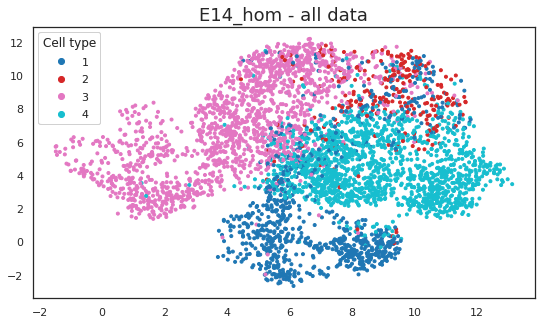

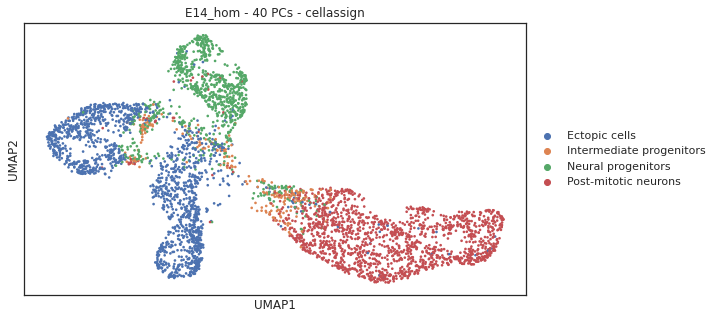

In [12]:
annotations = adata.obs['cell_type_num'].tolist()
umap_embedding = fit_umap(adata.X)

# UMAP on the whole dataset X
draw_umap(adata.X, annotations, embedding=umap_embedding, n_neighbors=15,
          min_dist=0.1, title=dataset+' - all data')

# UMAP on the first 40 PCs - cellassign annotations
sc.pl.umap(adata, color='cell_type', title=dataset+' - 40 PCs - cellassign')

# UMAP on the first 40 PCs - DE gene overlap annotations
# sc.pl.umap(adata, color='leiden_annotations', title=dataset+' - 40 PCs - DE manual annotation')

## Latent space of the autoencoder (scDeepCluster)

### Clustering with K-Means on the latent space:

#### n_clusters=10 in AE

Text(0.5, 1.0, 'E14_hom - latent space - 10 clusters')

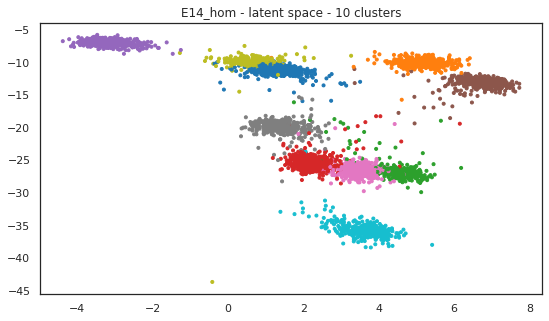

In [13]:
# n_clusters=10 in AE
kmeans = KMeans(n_clusters=10, random_state=42).fit(bottleneck_10)
plt.scatter(bottleneck_10.loc[:, 0], bottleneck_10.loc[:, 1],
            c=kmeans.labels_, cmap='tab10', marker='.')
plt.title(dataset + ' - latent space - 10 clusters')

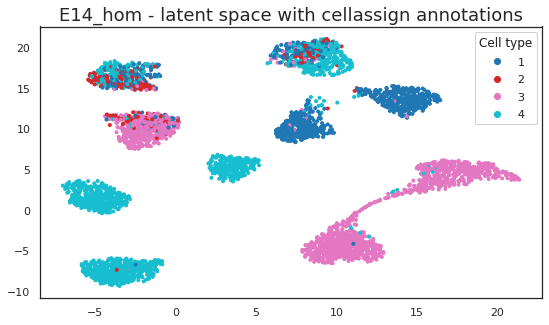

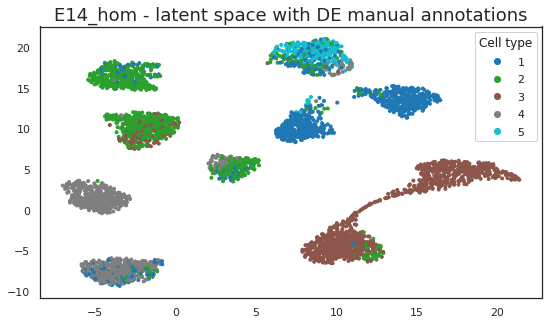

In [14]:
bottleneck_embedding = fit_umap(bottleneck_10, n_neighbors=15, min_dist=0.7)
draw_umap(bottleneck_10, annotations, embedding=bottleneck_embedding,
          n_neighbors=15, min_dist=0.9, title=dataset+' - latent space with cellassign annotations')

leiden_annotations = adata.obs['leiden_annotations'].map(label2num).tolist()
draw_umap(bottleneck_10, leiden_annotations, embedding=bottleneck_embedding,
          n_neighbors=15, min_dist=0.9, title=dataset+' - latent space with DE manual annotations')

#### n_clusters=4 in AE

Text(0.5, 1.0, 'E14_hom - latent space - 4 clusters')

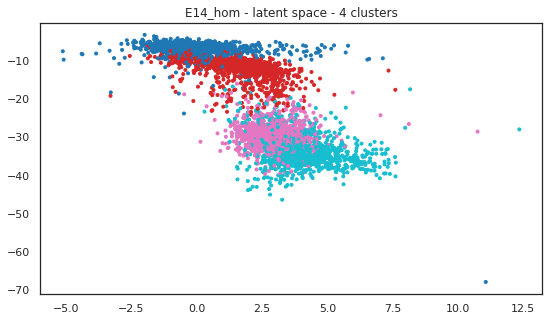

In [15]:
# n_clusters=4 in AE
kmeans = KMeans(n_clusters=4, random_state=42).fit(bottleneck_4)
plt.scatter(bottleneck_4.loc[:, 0], bottleneck_4.loc[:, 1],
            c=kmeans.labels_, cmap='tab10', marker='.')
plt.title(dataset+' - latent space - 4 clusters')

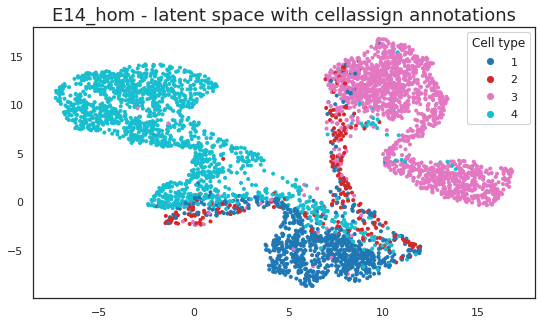

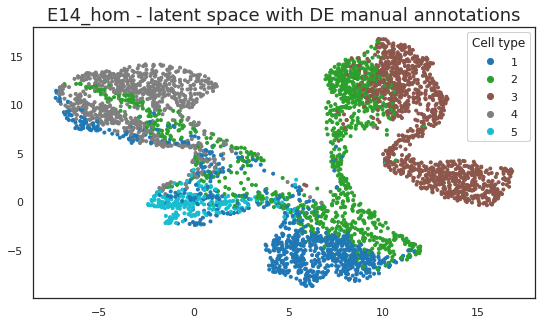

In [16]:
bottleneck_embedding_4 = fit_umap(bottleneck_4, n_neighbors=15, min_dist=0.7)
draw_umap(bottleneck_4, annotations, embedding=bottleneck_embedding_4,
          n_neighbors=15, min_dist=0.9, title=dataset+' - latent space with cellassign annotations')

draw_umap(bottleneck_4, leiden_annotations, embedding=bottleneck_embedding_4,
          n_neighbors=15, min_dist=0.9, title=dataset+' - latent space with DE manual annotations')

### Plot latent space (10 clusters) using the gene markers for each cell type:

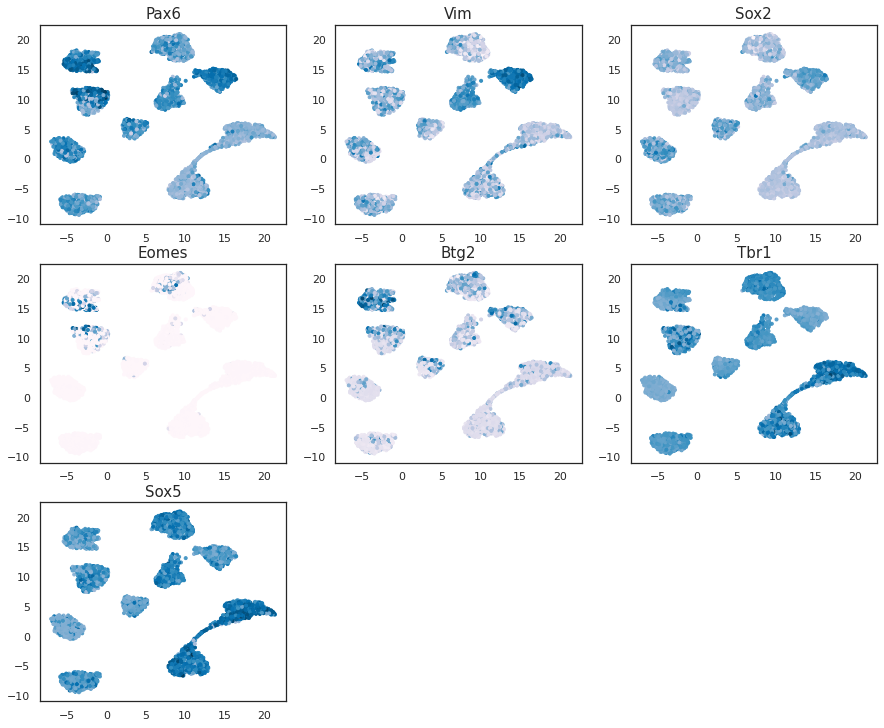

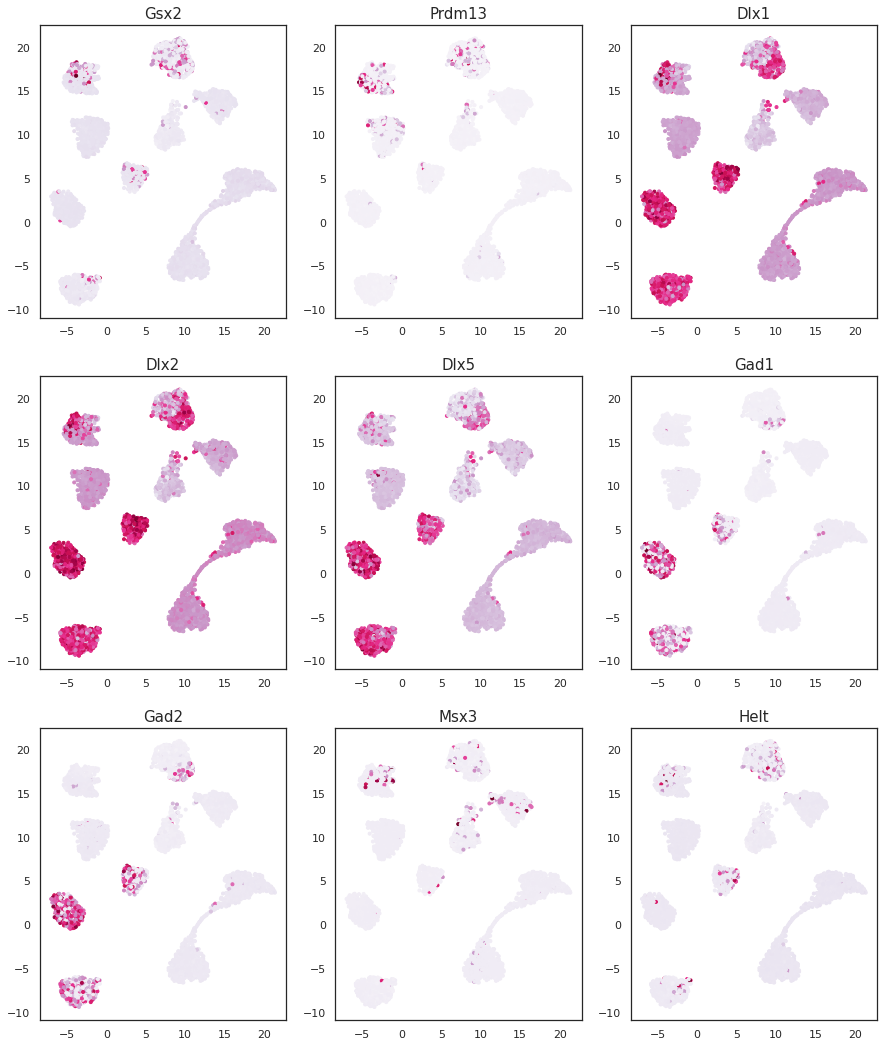

In [17]:
plot_umap_for_markers(bottleneck_embedding, adata, main_cell_types, cmap='PuBu')
plot_umap_for_markers(bottleneck_embedding, adata, marker_genes['ectopic'], cmap='PuRd')

### Plot latent space (10 clusters) using the markers from DE from E14_hom that characterise the ectopic cells:

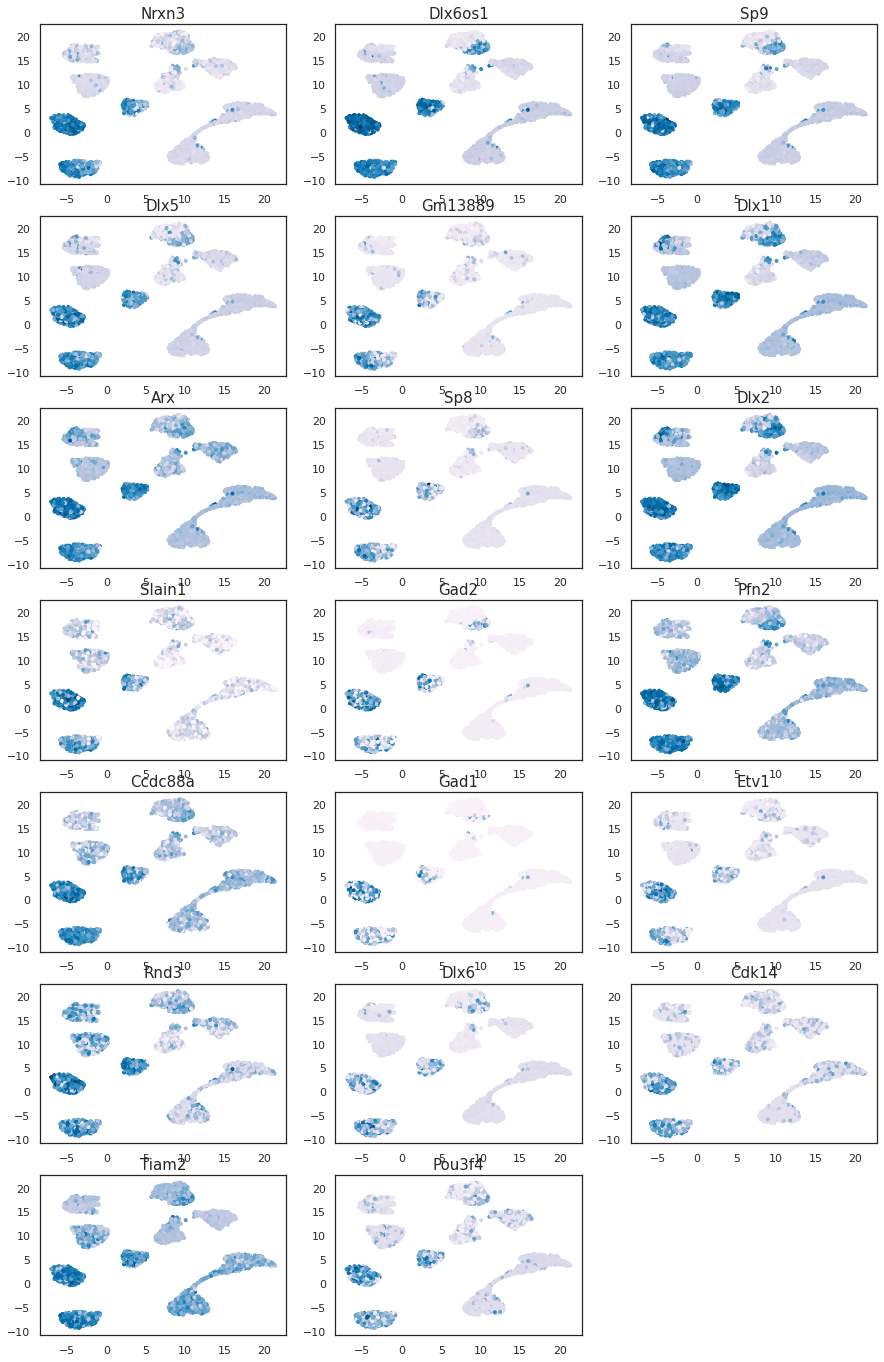

In [21]:
if dataset == 'E14_hom':
    E14 = adata
else:
    E14 = sc.read('../ann_data/exp_04/E14_hom_norm_variable_genes.h5ad')

E14_ectopic = pd.DataFrame(E14.uns['rank_genes_groups']['names'])['Ectopic cells'].head(20)
plot_umap_for_markers(bottleneck_embedding, adata, E14_ectopic, cmap='PuBu')

## Check presence of cell cycle phase

Plot UMAP for the initial dataset using the cell cycle phases:

Plot UMAP for the latent space using the cell cycle phases:

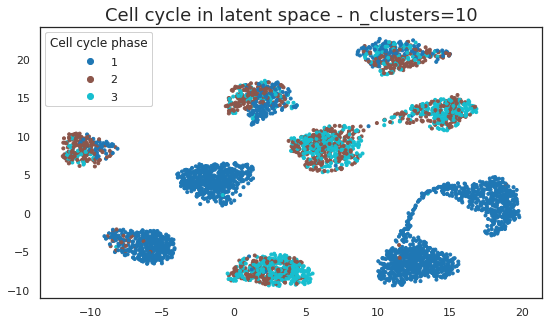

In [19]:
cc_phase_map = {'G1': 1, 'S': 2, 'G2M': 3}
draw_umap(bottleneck_10, adata.obs.phase.map(cc_phase_map).tolist(), n_neighbors=15, min_dist=0.9,
          legend_title='Cell cycle phase', title='Cell cycle in latent space - n_clusters=10')

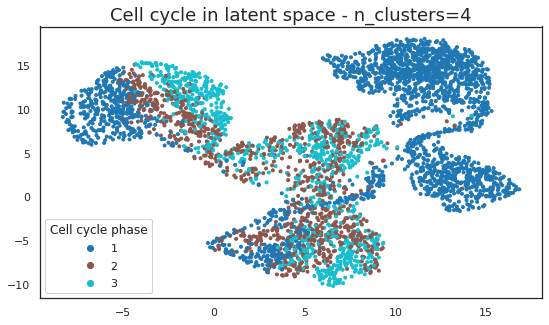

In [20]:
draw_umap(bottleneck_4, adata.obs.phase.map(cc_phase_map).tolist(), n_neighbors=15, min_dist=0.9,
          legend_title='Cell cycle phase', title='Cell cycle in latent space - n_clusters=4')